In [64]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
from scipy.optimize import minimize, minimize_scalar
from numpy.linalg import inv, det, eig
from scipy.stats import norm
import pandas as pd

warnings.filterwarnings('ignore')
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

In [2]:
# SmithWilson Class 정의
class SmithWilson:
    
    def __init__(self, alpha, UFR, term, rate):
        self.alpha = alpha
        self.UFR = UFR
        self.term = term
        self.rate = rate
        self.zeta = self.__calcZeta()
        return None
        
    def Wilson(self,t,u,order=0):
        alpha = self.alpha
        UFR = self.UFR
        if order == 0:
            wilson = np.exp(-UFR*(t+u))*(alpha*np.fmin(t,u) - np.exp(-alpha*np.fmax(t,u))*np.sinh(alpha*np.fmin(t,u)))
        elif order == 1:
            if t < u: wilson = np.exp(-UFR*t-(alpha+UFR)*u)*(UFR*np.sinh(alpha*t)-alpha*np.cosh(alpha*t)-alpha*(UFR*t-1)*np.exp(alpha*u))
            else: wilson = np.exp(-UFR*u-(alpha+UFR)*t)*((alpha+UFR)*np.sinh(alpha*u)-alpha*UFR*u*np.exp(alpha*t))
        elif order == 2:
            if t < u: wilson = np.exp(-UFR*t-(alpha+UFR)*u)*(-(alpha**2+UFR**2)*np.sinh(alpha*t)+2*alpha*UFR*np.cosh(alpha*t)+alpha*UFR*(UFR*t-2)*np.exp(alpha*u)) 
            else: wilson = np.exp(-UFR*u-(alpha+UFR)*t)*(alpha*UFR**2*u*np.exp(alpha*t)-(alpha+UFR)**2*np.sinh(alpha*u))
        else:
            print('유효한 Order가 아닙니다.')
        return wilson
    
    def __calcZeta(self):
        n = len(self.term)
        W = np.zeros([n,n])
        for i in range(n):
            for j in range(n):
                W[i,j] = self.Wilson(self.term[i],self.term[j])
        m = 1/(1+self.rate)**self.term
        mu = np.exp(-self.UFR*self.term)
        zeta = np.matmul(m-mu,np.linalg.inv(W))
        return zeta
        
    def Bond(self, t, order=0):
        bond = (-self.UFR)**order*np.exp(-self.UFR*t) + np.matmul(self.zeta, [self.Wilson(t, s, order) for s in sw.term])
        return bond
                                                                
    def YieldCurve(self, t):
        # t = 0 일 때 에러가 나는 것을 방지하기 위해 임의의 최소값 1e-6를 넣음
        t = np.fmax(t,1e-6)
        curve = 1/self.Bond(t)**(1/t) - 1
        return curve
    
    def Forward(self,t,order=0):
        if order == 0: forward = -self.Bond(t,1)/self.Bond(t,0)
        elif order == 1: forward = 1/self.Bond(t,0)*(-self.Bond(t,1)**2/self.Bond(t,0) + self.Bond(t,2))
        else: print('유효한 Order가 아닙니다.')
        return forward
    
    def __calcError(self, alpha, tol, M):
        sw = SmithWilson(alpha, self.UFR, self.term, self.rate)
        y = abs(tol-abs(sw.Forward(M)-self.UFR))
        return y
    
    def calcAlpha(self, tol=1e-4, M=60):
        # 수정 필요
        res = minimize_scalar(self.__calcError, method='bounded', bounds=(1e-3,1) ,args=(tol, M), options={'disp':False})
        return res.x
    
    def setAlpha(self, alpha):
        self.alpha = alpha
        self.zeta = self.__calcZeta()
        return None

In [3]:
# KalmanFilter Class 정의
class KalmanFilter:
    def __init__(self, A, B, Q, H, G, R):
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.G = G
        self.R = R
        
        self.m, self.n = H.shape

    def genStates(self, x, period=1):
        A, B, Q = self.A, self.B, self.Q
        x_gen = []
        
        for i in range(period):
            x = A@x+B+np.random.multivariate_normal(mean=np.zeros(self.n), cov=Q)
            x_gen.append(x)
        return x_gen
    
    def genMeasurement(self, x):
        H, G, R = self.H, self.G, self.R
        z = H@x+G+np.random.multivariate_normal(mean=np.zeros(self.m), cov=R)
        return z

In [4]:
# DNS Class 정의
class DNS(KalmanFilter):
    def __init__(self, params, tau, dt):
        self.tau = tau
        self.dt = dt
        self.setParams(params)
        
    def setParams(self, params):
        self.params = params
        lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma11, sigma21, sigma22, sigma31, sigma32, sigma33 = params
        dt, tau = self.dt, self.tau
        
        A = np.array([[1-kappa1*dt, 0, 0],
                      [0, 1-kappa2*dt, 0],
                      [0, 0, 1-kappa3*dt]])
        B = np.array([kappa1*theta1*dt, kappa2*theta2*dt, kappa3*theta3*dt])
        Q = np.array([[sigma11**2, sigma21, sigma31],
                      [sigma21, sigma22**2, sigma32],
                      [sigma31, sigma32, sigma33**2]])*dt
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
        G = np.zeros(len(tau))
        R = np.identity(len(tau))*eps**2
        
        super().__init__(A, B, Q, H, G, R)

In [139]:
# 모수 및 초기값
lambda_ = 0.60731
eps = 1e-3
kappa1 = 0.12844
kappa2 = 0.34156
kappa3 = 0.70498
theta1 = 0.04029
theta2 = -0.02018
theta3 = -0.00900
sigma11 = 0.00653
sigma21 = -0.00610
sigma22 = 0.00420
sigma31 = 0.00009
sigma32 = -0.00468
sigma33 = 0.01036

L0 = 0.0258
S0 = -0.0104
C0 = 0.0032

dt = 1/52
tau = np.array([1, 2, 3, 5, 10, 20])

In [140]:
# 모델 초기화
initParams = np.array([lambda_, eps,
                       kappa1, kappa2, kappa3,
                       theta1, theta2, theta3,
                       sigma11, sigma21, sigma22, sigma31, sigma32, sigma33])

kf = DNS(initParams, tau, dt)

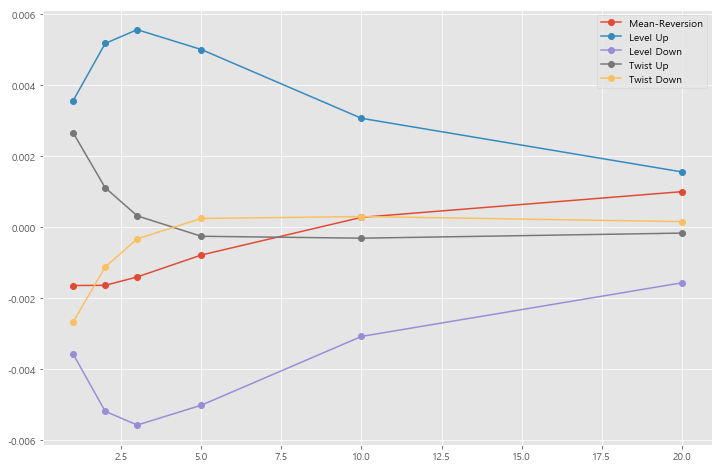

In [174]:
# 충격 시나리오
X0 = np.array([L0, S0, C0])
Theta = np.array([theta1, theta2, theta3])
Sigma = np.array([[sigma11, 0, 0],
                  [sigma21, sigma22, 0],
                  [sigma31, sigma32, sigma33]])
K = np.diag([kappa1, kappa2, kappa3])
K_inv = np.diag([1/kappa1, 1/kappa2, 1/kappa3])
exp_K = np.exp(-K)
I_3 = np.identity(3)
ones_3 = np.ones([3,3])


# 평균회귀 충격시나리오
평균회귀 = (ones_3-exp_K)@(Theta-X0)

# M
M = K_inv@(ones_3-exp_K)@Sigma

# W
LOT = 20
a = sum([(1-np.exp(-lambda_*tau))/(lambda_*tau) for tau in range(1, LOT+1)])
b = sum([(1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau) for tau in range(1, LOT+1)])
W = np.diag([LOT, a, b])

# N
N = W@M
lambda1, lambda2, lambda3 = eig(N)[0]
e1, e2, e3 = eig(N)[1]

# 수준/기울기 충격시나리오
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in range(1,LOT+1)])
S1 = sum(H@M@e1)
S2 = sum(H@M@e2)
angle = np.arctan(S2/S1)
신뢰수준 = 0.995
수준1 = norm.ppf(신뢰수준)*(np.cos(angle)*M@e1 + np.sin(angle)*M@e2)
수준2 = -norm.ppf(신뢰수준)*(np.cos(angle)*M@e1 + np.sin(angle)*M@e2)
기울기1 = norm.ppf(신뢰수준)*(np.cos(angle)*M@e2 - np.sin(angle)*M@e1)
기울기2 = -norm.ppf(신뢰수준)*(np.cos(angle)*M@e2 - np.sin(angle)*M@e1)

# 그래프
plt.figure(figsize=(12,8))
plt.plot(kf.tau, kf.H@평균회귀, '-o', label='Mean-Reversion')
plt.plot(kf.tau, kf.H@수준1, '-o', label='Level Up')
plt.plot(kf.tau, kf.H@수준2, '-o', label='Level Down')
plt.plot(kf.tau, kf.H@기울기1, '-o', label='Twist Up')
plt.plot(kf.tau, kf.H@기울기2, '-o', label='Twist Down')
plt.legend()
plt.show()

In [127]:
# 미래 상태 및 금리데이터 생성
np.random.seed(20190217)
x_cur = np.array([L0, S0, C0])
numSce = 200
x_gen, z_gen = [], []
for i in range(numSce):
    x = kf.genStates(x_cur, period=int(1/dt))[-1]
    z = kf.genMeasurement(x)
    x_gen.append(x)
    z_gen.append(z)

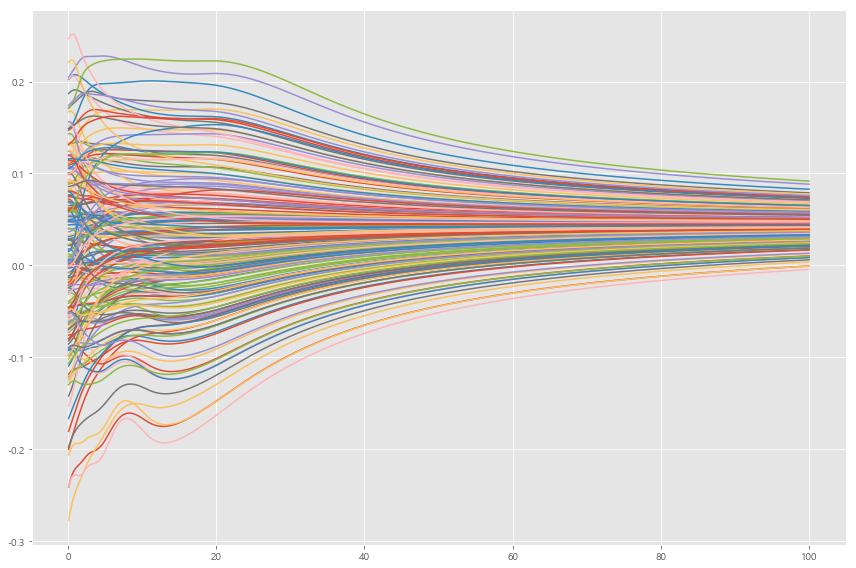

In [128]:
# 데이터 프레임 및 그래프 생성
plt.figure(figsize=(12,8))
x = np.arange(1/12, 100+1/12, 1/12)
만기 = np.round(x*12, 0).astype(int)
res = []
for i in range(numSce):
    sw = SmithWilson(0.01, np.log(1.045), tau, z_gen[i]) # 0.01은 α의 임의 초기값임
    sw.setAlpha(sw.calcAlpha()) # 해당 라인에서 α 계산됨
    y = sw.YieldCurve(x)
    plt.plot(x, y)
    df = pd.DataFrame(data={'시나리오번호':i+1, '만기': 만기, '금리': y})
    res.append(df)
df = pd.concat(res)
plt.tight_layout()
plt.savefig('금리시나리오_DNS.png')
plt.show()

In [8]:
# 엑셀 export
writer = pd.ExcelWriter('금리시나리오_DNS.xlsx', 'xlsxwriter')
df.to_excel(writer, index=False)
writer.save()
writer.close()